In [103]:
import numpy as np
import pickle
import torch
import random
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
import statistics
from collections import defaultdict

from ipywidgets import IntSlider, Output, widgets
from IPython.display import display, clear_output

%matplotlib inline

In [ ]:
# copied from gpleiss/temperature_scaling github repo
# use as follows

# orig_model = ... # create an uncalibrated model somehow
# valid_loader = ... # Create a DataLoader from the SAME VALIDATION SET used to train orig_model

# calibrated_model = ModelWithTemperature(orig_model)
# calibrated_model.set_temperature(valid_loader)

In [116]:
#this is needed to copy training data in google buckets produced by Terra to the mounted google drive
#it is not needed when the tables are already in google drive
#from google.colab import auth
#auth.authenticate_user()
#!gsutil cp  gs://<path> '/content/drive/My Drive/mutect3-training-data/dream1-normal.table'
#!gsutil cp gs://<path> '/content/drive/My Drive/mutect3-training-data/dream1-tumor.table'

In [19]:
NUM_READ_FEATURES = 11  #size of each read's feature vector from M2 annotation
NUM_INFO_FEATURES = 5   # size of each variant's info field tensor (3 components for HEC, one each for HAPDOM, HAPCOMP)
REF_DOWNSAMPLE = 10 # choose this many ref reads randomly
MIN_REF = 5
ARTIFACT_POPAF_THRESHOLD = 5.9 # only let things absent from gnomAD be artifacts out of caution
GERMLINE_POPAF_THRESHOLD = 1 #also very cautious.  There are so many germline variants we can be wasteful!
TLOD_THRESHOLD = 6 # we are classified artifacts other than sequencing errors described by base qualities
NON_ARTIFACT_PER_ARTIFACT = 50 #ratio of non-artifact to artifact in unsupervised training data

In [20]:
#as a quick and robust estimate of the mean for the purpose of normalizing, we will take the median of medians of subsets
#for example, take the median of each group of 100 read sets, then take the median of those
NUM_SETS_PER_MEAN = 100

def find_normalization(data):
    medians = []
    spreads = []
    buffer = []
    for n, (ref_tensor, _, _) in enumerate(data):
        buffer.append(ref_tensor)
        
        if n > 0 and n % NUM_SETS_PER_MEAN == 0:
            medians.append(torch.quantile(torch.cat(buffer, dim=0), 0.5, dim=0))
            low_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.02, dim=0)
            high_quantile = torch.quantile(torch.cat(buffer, dim=0), 0.98, dim=0)
            spreads.append(high_quantile - low_quantile)
            buffer.clear()
    mu = torch.median(torch.stack(medians), dim=0).values
    sigma = torch.median(torch.stack(spreads), dim=0).values
    
    return mu, sigma

def normalize(data, mu, sigma):
    return [((ref - mu) / sigma, (alt - mu) / sigma, is_artifact) for ref, alt, is_artifact in data]

In [25]:
def index_if_exists(lis, element):
    return lis.index(element) if element in lis else None

def get_indices(lis, elements):
    return tuple(index_if_exists(lis, element) for element in elements)

ALLELE_SEPARATOR = '|'
# get the ref and alt tensors from the VariantsToTable raw output, convert to torch tensors, downsample ref if needed
def get_read_tensors(token, ref_downsample=None):
    tokens = token.split(ALLELE_SEPARATOR)
    ref, alt = tuple(np.fromstring(x, dtype=int, sep=',').reshape((-1, NUM_READ_FEATURES)) for x in tokens)
    ref, alt = torch.from_numpy(ref).float(), torch.from_numpy(alt).float()
    if (ref_downsample is not None and len(ref) > ref_downsample):
        ref = ref[torch.randperm(len(ref))[:ref_downsample]]
    return ref, alt

class TableReader:
    def __init__(self, header_tokens, tumor_sample, normal_sample=None):
        
        # site data
        self.chrom_idx, self.pos_idx, self.ref_allele_idx, self.alt_allele_idx, self.popaf_idx = \
            get_indices(header_tokens, ["CHROM", "POS", "REF", "ALT", "POPAF"])
        
        # variant data
        self.filter_idx, self.status_idx, self.tlod_idx, self.tumor_dp_idx, self.tumor_idx = \
            get_indices(header_tokens, ["FILTER", "STATUS", "TLOD", tumor_sample + ".DP", tumor_sample + ".FRS"])
        
        # assembly complexity data -- haplotype equivalence counts, haplotype complexity, haplotype dominance
        self.hec_idx, self.hapcomp_idx, self.hapdom_idx = get_indices(header_tokens, ["HEC", "HAPCOMP", "HAPDOM"])
        
        # optional normal data
        if normal_sample is not None:
            self.normal_idx, self.normal_dp_idx = get_indices(header_tokens, [normal_sample + ".FRS", normal_sample + ".DP"])
    
    def hec(self, tokens):
        counts = tokens[self.hec_idx].split(",")
        if (len(counts) == 1):
            return [1.0, 0.0, 0.0]
        else:
            counts = [float(x) for x in counts]
            while len(counts) < 3:
                counts.append(0.0)
            total = counts[0] + counts[1] + counts[2]
            return [counts[0]/total, counts[1]/total, counts[2]/total]
        return int(tokens[self.hec_idx])
    
    def hapcomp(self, tokens):
        return int(tokens[self.hapcomp_idx])
    
    def hapdom(self, tokens):
        return float(tokens[self.hapdom_idx])
        
    def chrom(self, tokens):
        return tokens[self.chrom_idx]
    
    def pos(self, tokens):
        return int(tokens[self.pos_idx])
    
    def ref_allele(self, tokens):
        return tokens[self.ref_allele_idx]
    
    def alt_allele(self, tokens):
        return tokens[self.alt_allele_idx]
    
    def popaf(self, tokens):
        return float(tokens[self.popaf_idx])
    
    def filters(self, tokens):
        return set(tokens[self.filter_idx].split(","))
    
    def status(self, tokens):
        return tokens[self.status_idx]
    
    def tlod(self, tokens):
        return float(tokens[self.tlod_idx])
    
    def tumor_dp(self, tokens):
        return int(tokens[self.tumor_dp_idx])
    
    def tumor_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.tumor_idx], ref_downsample)
    
    def normal_dp(self, tokens):
        return int(tokens[self.normal_dp_idx])
    
    def normal_ref_and_alt(self, tokens, ref_downsample=None):
        return get_read_tensors(tokens[self.normal_idx], ref_downsample)

In [47]:
M2_KEPT_FILTERS = {"contamination", "germline", "weak_evidence"} #M2 filters that M3 won't override

# this takes a table from VariantsToTable and produces a list of either
# (ref tensor, alt tensor, and unsupervised label based on AF) if is_training = true
# (ref tensor, alt tensor, (position, filters, status)) if is_training = false
def make_tensors(raw_file, is_training, sample_name, normal_sample_name=None):
    data = []
    artifact_counts_and_depths = []
            
    # simple online method for balanced data set where for each k-alt-read artifact there are 
    # NON_ARTIFACT_PER_ARTIFACT (downsampled) k-alt-read non-artifacts.  That is, alt count is not an informative feature.
    unmatched_artifact_counts = []
    
    still_filtered = 0
    
    with open(raw_file) as fp: 
        reader = TableReader(fp.readline().split(), sample_name, normal_sample_name)
        
        for n, line in enumerate(fp):
            if n % 100000 == 0:
                print("Processing line " + str(n))
                
            tokens = line.split()
            ref_allele, alt_allele, popaf = reader.ref_allele(tokens), reader.alt_allele(tokens), reader.popaf(tokens)
            tlod, tumor_dp, filters, status = reader.tlod(tokens), reader.tumor_dp(tokens), reader.filters(tokens), reader.status(tokens)
            position = reader.chrom(tokens) + ":" + str(reader.pos(tokens))

            # we trust the germline, contamination, and weak evidence filters.  M3 will not override these.
            if not is_training and M2_KEPT_FILTERS.intersection(filters):
                still_filtered += 1
                continue        

            # don't bother processing tensors if it's a plain old sequencing error or if popaf is middling
            if tlod < TLOD_THRESHOLD or (GERMLINE_POPAF_THRESHOLD < popaf < ARTIFACT_POPAF_THRESHOLD):
                continue

            #TODO: this considers everything with low AF, low POPAF, and TLOD sufficiently high not to be plain old
            #TODO: sequencing error to be an artifact.  This is not the case when we are training on a tumor sample.
            #TODO: however, it might still work if we have some real variants in the training data
            ref_tensor, alt_tensor = reader.tumor_ref_and_alt(tokens, REF_DOWNSAMPLE)
            alt_count = len(alt_tensor)
            if alt_count == 0 or len(ref_tensor) < MIN_REF:
                continue
                
            af = alt_count / tumor_dp
            if is_training:
                normal_af = 0
                if normal_sample_name is not None:
                    normal_dp = reader.normal_dp(tokens)
                    normal_ref, normal_alt = reader.normal_ref_and_alt(tokens, REF_DOWNSAMPLE)
                    normal_af = 0 if normal_dp == 0 else len(normal_alt) / normal_dp
                    #TODO: output normal alt reads in dataset

                #primitive calling of artifact vs germline het!!
                if normal_af < 0.2 and af < 0.2 and popaf > ARTIFACT_POPAF_THRESHOLD: 
                    unmatched_artifact_counts.extend([alt_count]*NON_ARTIFACT_PER_ARTIFACT)
                    artifact_counts_and_depths.append((alt_count, tumor_dp))
                elif normal_af > 0.35 and af > 0.35 and popaf < GERMLINE_POPAF_THRESHOLD and unmatched_artifact_counts:
                    downsample_count = min(alt_count, unmatched_artifact_counts.pop())
                    alt_tensor = alt_tensor[torch.randperm(alt_count)[:downsample_count]]
                else:
                    continue
                    
            # assembly complexity site-level annotations
            info = reader.hec(tokens)
            info.append(reader.hapcomp(tokens))
            info.append(reader.hapdom(tokens))
            info_tensor = torch.FloatTensor(info)

            # use AF for unsupervised training;
            is_artifact = (1 if af < 0.2 else 0) if is_training else (1 if (status == "FP" or status == "FTN") else 0)            
            data.append((ref_tensor, alt_tensor, info_tensor, (position, filters, is_artifact)))

    if not is_training:
        print(str(still_filtered) + " variants skipped due to trusted M2 filters.")
    return data, artifact_counts_and_depths

In [48]:
tumor_file = '/Users/davidben/broad/mutect3/dream1-tumor.table'
normal_file = '/Users/davidben/broad/mutect3/dream1-normal.table'
pickled_train_file = '/Users/davidben/broad/mutect3/dream1-tumor-train.pickle'
pickled_test_file = '/Users/davidben/broad/mutect3/dream1-tumor-test.pickle'

tumor_sample = 'synthetic.challenge.set1.tumor'
normal_sample = 'synthetic.challenge.set1.normal'

# we can train on either the tumor OR the normal!
#first find unnormalized data
train_data, artifact_counts_and_depths = make_tensors(tumor_file, True, tumor_sample, normal_sample)
test_data, _ = make_tensors(tumor_file, False, tumor_sample, normal_sample)

#mu, sigma = find_normalization(train_data)
#train_data = normalize(train_data, mu, sigma)
#test_data = normalize(test_data, mu, sigma)

with open(pickled_train_file, 'wb') as f:
    pickle.dump(train_data, f)
    
with open(pickled_test_file, 'wb') as f:
    pickle.dump(test_data, f)

Processing line 0
Processing line 100000
Processing line 200000
Processing line 300000
Processing line 400000
Processing line 500000
Processing line 600000
Processing line 700000
Processing line 800000
Processing line 900000
Processing line 1000000
Processing line 1100000
Processing line 1200000
Processing line 1300000
Processing line 1400000
Processing line 1500000
Processing line 1600000
Processing line 1700000
Processing line 1800000
Processing line 1900000
Processing line 2000000
Processing line 2100000
Processing line 2200000
Processing line 2300000
Processing line 2400000
Processing line 2500000
Processing line 2600000
Processing line 2700000
Processing line 2800000
Processing line 2900000
Processing line 3000000
Processing line 3100000
Processing line 3200000
Processing line 3300000
Processing line 3400000
Processing line 3500000
Processing line 3600000
Processing line 3700000
Processing line 3800000
Processing line 3900000
Processing line 4000000
Processing line 4100000
Process

In [49]:
class Mutect3Dataset(Dataset):
    
    def __init__(self, pickled_file, augment):
        with open(pickled_file, 'rb') as f:
            self.data = pickle.load(f)
            random.shuffle(self.data)
        #elements of feature set are
        # map qual, base qual, is first of pair, is reverse,
        # left read position, right read position
        # fragment length, left fragment position, right fragment position
        # SNVs wrt best haplotype, indels wrt best haplotype
        self.scale = torch.tensor([60, 30, 1, 1, 100, 100, 500, 500, 500, 1, 1])
        
        self.augment = augment
        
    def __len__(self):
        return len(self.data)
    
    # format is ref_tensor, alt_tensor, info_tensor, (position, filters, is_artifact)
    def __getitem__(self, index):
        ref_tensor, alt_tensor, info_tensor, other_stuff = self.data[index]
        
        if self.augment:
            # strand flip symmetry
            if torch.rand(1).item() < 0.5:
                ref_tensor[:,3] = 1 - ref_tensor[:,3]
                alt_tensor[:,3] = 1 - alt_tensor[:,3]

            # left-right symmetry
            if torch.rand(1).item() < 0.5:
                ref_tensor[:,[4,5]] = ref_tensor[:,[5,4]]
                alt_tensor[:,[4,5]] = alt_tensor[:,[5,4]]
                ref_tensor[:,[7,8]] = ref_tensor[:,[8,7]]
                alt_tensor[:,[7,8]] = alt_tensor[:,[8,7]]
            
            # downsample alts
            if torch.rand(1).item() < 0.5:
                alt_count = len(alt_tensor)
                downsample_count = torch.randint(alt_count,(1,)).item() + 1
                alt_tensor = alt_tensor[torch.randperm(alt_count)[:downsample_count]]
        
        return ref_tensor/self.scale, alt_tensor/self.scale, info_tensor, other_stuff

In [50]:
data = Mutect3Dataset(pickled_train_file, False)
train_len = int(0.9*len(data))
valid_len = len(data) - train_len
train, valid = random_split(data, lengths=[train_len, valid_len])
test = Mutect3Dataset(pickled_test_file, False)
print(len(train), len(valid), len(test))

276960 30774 10351


Measure the quality of our self-supervised labelling.  We calculate the number of "artifacts" in our training/validation data that are actually 'PASS'

In [114]:
print(len([_ for datum in data if 'PASS' in datum[3][1] and datum[3][2] == 1]))
print(len([_ for datum in data if 'PASS' not in datum[3][1] and datum[3][2] == 0]))

19
301700


In [57]:
artifact_alt_counts = np.array([len(datum[1]) for datum in data if datum[3][2] == 1] )
non_artifact_alt_counts = np.array([len(datum[1]) for datum in data if datum[3][2] == 0] )
print((np.bincount(non_artifact_alt_counts)[0:20]/NON_ARTIFACT_PER_ARTIFACT).tolist())
print((np.bincount(artifact_alt_counts)[0:20]).tolist())

[0.0, 172.0, 731.7, 971.36, 1079.8, 902.12, 615.0, 449.24, 231.94, 217.44, 135.08, 70.96, 73.88, 66.82, 51.74, 44.88, 35.18, 31.8, 22.5, 18.78]
[0, 172, 731, 968, 1074, 896, 610, 447, 227, 218, 134, 68, 71, 67, 53, 45, 35, 33, 22, 20]


(array([  3.,   4.,   6.,  10.,  13.,  28.,  50.,  55.,  50.,  48.,  61.,
         86.,  78.,  88., 107., 161., 170., 155., 183., 257., 143., 231.,
        125., 224., 197., 172., 139., 213., 217., 131., 252., 142., 213.,
        139., 152., 181., 151., 150., 187., 118., 100., 173.,  84.,  81.,
        102., 114.,  75., 108.,  71.,  36.]),
 array([0.00704225, 0.01087087, 0.01469949, 0.01852812, 0.02235674,
        0.02618536, 0.03001398, 0.0338426 , 0.03767122, 0.04149984,
        0.04532846, 0.04915708, 0.0529857 , 0.05681432, 0.06064294,
        0.06447156, 0.06830018, 0.0721288 , 0.07595742, 0.07978604,
        0.08361467, 0.08744329, 0.09127191, 0.09510053, 0.09892915,
        0.10275777, 0.10658639, 0.11041501, 0.11424363, 0.11807225,
        0.12190087, 0.12572949, 0.12955811, 0.13338673, 0.13721535,
        0.14104397, 0.14487259, 0.14870121, 0.15252984, 0.15635846,
        0.16018708, 0.1640157 , 0.16784432, 0.17167294, 0.17550156,
        0.17933018, 0.1831588 , 0.18698742, 0.

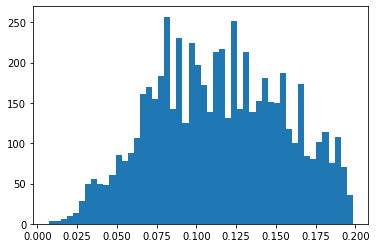

In [58]:
afs = [count / depth for count,depth in artifact_counts_and_depths]
plt.hist(afs, bins=50)

0
Parameter containing:
tensor(44.9919, requires_grad=True) Parameter containing:
tensor(62.9183, requires_grad=True)


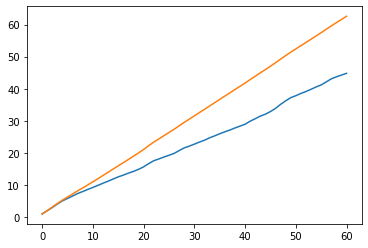

In [130]:
#Now let's learn the spectrum of artifact allele fractions in order to combine our calibrated classifier with priors
# to get a posterior probability
# the model is alt count ~ BetaBinomial(alpha, beta, depth)
# and we want to learn alpha, beta by MLE

alpha = nn.Parameter(torch.tensor(1.))
beta = nn.Parameter(torch.tensor(1.))

learning_rate = 1e-2
optimizer = torch.optim.Adam([alpha, beta], lr=learning_rate)

alpha_vals = []
beta_vals = []

for epoch in range(1):
    print(epoch)
    for step, (k,n) in enumerate(artifact_counts_and_depths):
        nll = torch.lgamma(n + alpha + beta) + torch.lgamma(alpha) + torch.lgamma(beta) \
            - torch.lgamma(k + alpha) + torch.lgamma(n - k + beta) - torch.lgamma(alpha + beta)
        optimizer.zero_grad()
        nll.backward()
        optimizer.step()

        if step % 100 == 0:
            alpha_vals.append(alpha.item())
            beta_vals.append(beta.item())

plt.plot(alpha_vals)
plt.plot(beta_vals)
print(alpha, beta)

In [59]:
class LinearStack(nn.Module):
    #layer_sizes starts from the input and ends with the output
    #optional batch normalization
    def __init__(self, layer_sizes, batch_normalize=False, batch_normalize_input=False):
        
        super(LinearStack, self).__init__()
        
        self.layers = nn.ModuleList()
        for k in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[k], layer_sizes[k+1]))
            
        self.bn = nn.ModuleList()
        
        self.batch_normalize_input = False
        if batch_normalize_input:
            self.batch_normalize_input = True
            self.bn_input = nn.BatchNorm1d(num_features=layer_sizes[0])
        
        if batch_normalize:  
            #batch normalize after every linear transformation
            for size in layer_sizes[1:]:
                self.bn.append(nn.BatchNorm1d(num_features=size))
            
    def forward(self, x):
        if self.batch_normalize_input:
            x = self.bn_input(x)

        # Feedforward -- note that last layer has no non-linearity
        for n, layer in enumerate(self.layers):
            x = layer(x)
            if self.bn:
                x = self.bn[n](x)
            if n < len(self.layers) - 1:
                x = nn.functional.relu(x)

        return x

In [138]:
class ReadSetClassifier(nn.Module):
    #embedding layer sizes include input, aggregation hidden layer sizes do not include its input which is 
    # the embedding output, nor its output which is a binary classification
    def __init__(self, embedding_layer_sizes, info_embedding_layer_sizes, aggregation_hidden_layer_sizes):
        super(ReadSetClassifier, self).__init__()
        
        # phi is the universal read embedding function
        self.phi = LinearStack(embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.embedding_dimension = embedding_layer_sizes[-1] #this is the embedding dimension of one read
        
        #omega is the universal embedding of info field variant-level data
        self.omega = LinearStack(info_embedding_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        self.info_embedding_dimension = info_embedding_layer_sizes[-1]
        
        # rho is the universal aggregation function
        # the *2 is for the use of both ref and alt reads
        self.rho = LinearStack([2*self.embedding_dimension + self.info_embedding_dimension] + aggregation_hidden_layer_sizes, batch_normalize=False, batch_normalize_input=False)
        
        # the scalar anomaly score function
        self.score = nn.Linear(aggregation_hidden_layer_sizes[-1], 1)
        
        # the center of the decision boundary is 1D score space
        self.decision_boundary = nn.Parameter(torch.tensor(1.0))
        
    # see the custom collate_fn for information on the batched input
    def forward(self, ref_reads, alt_reads, ref_counts, alt_counts, info):
    
        # broadcast the embedding to each read
        num_sets = len(ref_counts)
        
        phi_ref = torch.sigmoid(self.phi(ref_reads))
        phi_alt = torch.sigmoid(self.phi(alt_reads))
        omega_info = torch.sigmoid(self.omega(info))
                        
        ref_end = torch.cumsum(ref_counts, dim=0)
        ref_slices = [slice(0 if n == 0 else ref_end[n-1],ref_end[n]) for n in range(num_sets)]
        alt_end = torch.cumsum(alt_counts, dim=0)
        alt_slices = [slice(0 if n == 0 else alt_end[n-1],alt_end[n]) for n in range(num_sets)]
               
        # note that after taking means, tensors are now num_sets x embedding dimension
        ref_means = torch.cat([torch.mean(phi_ref[slice], dim=0, keepdim=True) for slice in ref_slices], dim=0)
        alt_means = torch.cat([torch.mean(phi_alt[slice], dim=0, keepdim=True) for slice in alt_slices], dim=0)

        #stack the ref and alt means and info side-by-side so that each row of the resulting
        # 2D tensor is (mean ref 1, . . . mean ref D, mean alt 1, . . . mean alt D, ref count)
        stacked_embeddings = torch.cat((ref_means, alt_means, omega_info), dim=1)
                
        # broadcast the aggregation over the batch, then broadcast the DevNet anomaly score,
        scores = torch.abs(self.score(self.rho(stacked_embeddings)))
        
        output = (scores - self.decision_boundary) * torch.sqrt(torch.unsqueeze(alt_counts,1).float())
        
        # note that no non-linearity is applied here because nn.BCEWithLogitsLoss() includes
        # the sigmoid.  Thus when classifying we will have to apply the sigmoid explicitly
        # note also that we return the scores in order to pass it to a custom loss function
        return torch.squeeze(output), torch.squeeze(scores)

In [108]:
class TemperatureScaledReadSetClassifier(nn.Module):
    """
    A thin decorator, which wraps the above model with temperature scaling
    NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(TemperatureScaledReadSetClassifier, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.tensor(1.5))

    def forward(self, ref_reads, alt_reads, ref_counts, alt_counts, info):
        logits = self.model(ref_reads, alt_reads, ref_counts, alt_counts, info)[0]
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        # Expand temperature to match the size of logits
        return logits / self.temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        nll_criterion = nn.BCEWithLogitsLoss()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for ref_reads, alt_reads, ref_counts, alt_counts, info, labels, positions, filters in valid_loader:
                logits = self.model(ref_reads, alt_reads, ref_counts, alt_counts, info)[0]
                logits_list.append(logits)
                labels_list.append(labels)
            logits = torch.cat(logits_list)
            labels = torch.cat(labels_list)

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f' % (before_temperature_nll))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f' % (after_temperature_nll))

        return self

In [61]:
# because our read sets have different sizes, we can't just form a batch by naively stacking tensors
# thus we need a custom collate function for our data loader (and we will have to be aware of the custom format the
# data loader provides for training)

# input batch is a list of tuples (ref_tensor, alt_tensor, info_tensor, (position, filters, is_artifact, m2_artifact))
# where ref_reads and alt_reads are (2D tensors, one row per read),
# info_tensor is a 1D tensor, one tensor for each variant
# position is a string, filters is a set of strings
# is_artifact and m2_artifact are binary 0/1 scalars

# collated batch contains:
# ref (alt) reads: 2D tensors of ALL ref (alt) reads, not separated by set.
# ref (alt) counts: number of reads in ref (alt) read sets, in same order as read tensors
# info: 2D tensor of info fields, one row per variant
# labels: 1D tensor of 0 if non-artifact, 1 if artifact
# Example: if we have two input data, one with alt reads [[0,1,2], [3,4,5] and the other with 
# alt reads [[6,7,8], [9,10,11], [12,13,14] then the output alt reads tensor is
# [[0,1,2], [3,4,5], [6,7,8], [9,10,11], [12,13,14]] and the output counts are [2,3]
# inside the model, the counts will be used to separate the reads into sets
def collate_read_sets(batch):
    ref_counts = torch.IntTensor([len(item[0]) for item in batch])
    alt_counts = torch.IntTensor([len(item[1]) for item in batch])
    ref = torch.cat([item[0] for item in batch], dim=0)
    alt = torch.cat([item[1] for item in batch], dim=0)
    info = torch.stack([item[2] for item in batch], dim=0)
    labels = torch.FloatTensor([item[3][2] for item in batch])
    
    positions = [item[3][0] for item in batch]
    filters = [item[3][1] for item in batch]
    
    return ref, alt, ref_counts, alt_counts, info, labels, positions, filters

In [62]:
def round_alt_count_for_binning(alt_count):
    if alt_count < 15:
        return alt_count
    else:
        return alt_count - alt_count % 5

In [63]:
# penalize artifact scores of non-artifacts for being large
# this helps us achieve one-class classification, the ability to recognize artifacts as anomalous 
# even with few training examples by virtue of them not fitting the pattern of non-artifacts.  Such a scheme only
# works when the score (or representation) of non-anomalies is forced into a compact space
# inputs are 1-D tensors -- a batch of scores and a batch of labels, 0 for non-artifact, 1 for artifact
# we only regularize non-artifacts
def artifact_score_regularizer(scores, labels):
    return torch.sum(nn.functional.relu(scores - 1)*(1.0 - labels))

In [64]:
def plot_learning_curves(train_losses, valid_losses):
    fig = plt.figure()
    learning_curve = fig.gca()
    epochs = range(1, len(train_losses) + 1)
    learning_curve.plot(epochs, train_losses, label = "training")
    learning_curve.plot(epochs, valid_losses, label = "validation")
    learning_curve.set_title("Learning curves")
    learning_curve.set_xlabel("epoch")
    learning_curve.set_ylabel("loss")
    learning_curve.legend() 
    return fig, learning_curve

In [65]:
# confusion_matrices is dict of alt count to 2x2 [[,],[,]] confusion matrices where 0/1 is non-artifact/artifact
# and 1st index is truth, 2nd index is prediction
def plot_sensitivities(confusion_matrices, name):
    counts = []
    variant_sensitivities = []
    artifact_sensitivities = []
    for alt_count_bin in sorted(confusion_matrices.keys()):
        matrix = confusion_matrices[alt_count_bin]
        if (matrix[0][0] + matrix[0][1]) == 0 or (matrix[1][0] + matrix[1][1]) == 0:
            continue

        counts.append(alt_count_bin)
        variant_sensitivities.append(matrix[0][0] / (matrix[0][0] + matrix[0][1]))
        artifact_sensitivities.append(matrix[1][1] / (matrix[1][0] + matrix[1][1]))

    fig = plt.figure()
    accuracy_curve = fig.gca()
    accuracy_curve
    accuracy_curve.clear()
    accuracy_curve.plot(counts, variant_sensitivities, label = "variant sensitivity")
    accuracy_curve.plot(counts, artifact_sensitivities, label = "artifact sensitivity")
    accuracy_curve.set_title("Variant and artifact sensitivity by alt count for " + name)
    accuracy_curve.set_xlabel("alt count")
    accuracy_curve.set_ylabel("sensitivity")
    accuracy_curve.legend()
    return fig, accuracy_curve

In [66]:
def plot_scores(artifact_scores, non_artifact_scores, name):
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for n, count in enumerate([2, 3, 5, 7, 9, 12, 16, 20, 25]):
        row = int(n/3)
        col = n % 3
        ax[row, col].hist(non_artifact_scores[count], bins=50, alpha = 0.5, label = 'non-artifacts')
        ax[row, col].hist(artifact_scores[count], bins=50, alpha = 0.5, label = 'artifacts')
        ax[row, col].set_title("Alt count " + str(count) + " for " + name)
        ax[row, col].set_xlabel("score")
        ax[row, col].legend()
    return fig, ax

In [87]:
class ValidationStats:
    def __init__(self):
        self.confusion_by_count = defaultdict(lambda: [[0,0],[0,0]])
        self.confusion = [[0,0],[0,0]]
        
        self.artifact_scores_by_count = defaultdict(list)
        self.non_artifact_scores_by_count = defaultdict(list)
        
        self.missed_artifacts_by_count = defaultdict(list)
        self.missed_variants_by_count = defaultdict(list)
        
    # prediction and truth are 0 if not artifact, 1 if artifact
    def add(self, alt_count, truth, prediction, score, filters, position):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        self.confusion_by_count[alt_count_bin][truth][prediction] += 1
        self.confusion[truth][prediction] += 1
        (self.artifact_scores_by_count if truth == 1 else self.non_artifact_scores_by_count)[alt_count_bin].append(score)
        
        if truth == 1 and prediction == 0:
            self.missed_artifacts_by_count[alt_count_bin].append((score, position, filters))
        elif truth == 0 and prediction == 1:
            self.missed_variants_by_count[alt_count_bin].append((score, position, filters))
        
    def confusion_matrices(self):
        return self.confusion_by_count
    
    def confusion(self):
        return self.confusion
    
    def sensitivity(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[0][1])
    
    def precision(self):
        return self.confusion[0][0]/(self.confusion[0][0] + self.confusion[1][0])
    
    def artifact_scores(self):
        return self.artifact_scores_by_count
    
    def non_artifact_scores(self):
        return self.non_artifact_scores_by_count
    
    def worst_missed_variants(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_variants_by_count[alt_count_bin], key=lambda x: -x[0])
    
    def worst_missed_artifacts(self, alt_count):
        alt_count_bin = round_alt_count_for_binning(alt_count)
        #sort from highest score to lowest
        return sorted(self.missed_artifacts_by_count[alt_count_bin], key=lambda x: x[0])
        
       
    

In [123]:
#note the m2 filters to keep here are different from those used to generate the training data
# above, they were filters that are not artifacts, such as germline, contamination, and weak evidence
# here, they are artifact filters that we intend to use in M3, such as the normal artifact filter

#threshold is threshold of logit prediction for considering variant an artifact -- this is a quick way to
# explore translating likelihoods from balanced training to posteriors, which we will alter do in a principled way
def get_validation_stats(model, loader, m2_filters_to_keep = {}, threshold=0.0):
    stats = ValidationStats()

    model.train(False)
    for ref_reads, alt_reads, ref_counts, alt_counts, info, labels, positions, filters in loader:
        predictions, scores = model(ref_reads, alt_reads, ref_counts, alt_counts, info)              
        for n in range(len(alt_counts)):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 1 if (predictions[n] > threshold or filters[n].intersection(m2_filters_to_keep)) else 0   
            stats.add(alt_counts[n].item(), truth, pred, scores[n].item(), filters[n], positions[n])
            
    return stats

In [115]:
# get the same stats for Mutect2 using the M2 filters and truth labels
def get_m2_validation_stats(loader):
    stats = ValidationStats()

    for ref_reads, alt_reads, ref_counts, alt_counts, info, labels, positions, filters in loader:
        for n in range(len(alt_counts)):  
            truth = 1 if labels[n].item() > 0.5 else 0
            pred = 0 if 'PASS' in filters[n] else 1  
            score = 10 if pred == 1 else 0
            stats.add(alt_counts[n].item(), truth, pred, scores, filters[n], positions[n])
            
    return stats

In [139]:
BATCH_SIZE = 64

train_labels = [datum[3][2] for datum in train]
valid_labels = [datum[3][2] for datum in valid]

model = ReadSetClassifier([NUM_READ_FEATURES, 20, 20], [NUM_INFO_FEATURES, 10], [10]).float()
class_counts = torch.FloatTensor(np.bincount(train_labels).tolist())
samples_per_epoch = 20*int(class_counts[1]) #epoch should roughly go over every artifact O(1) times, but more than once because we want to squeeze more out of the non-artifact

class_weights = 1.0/class_counts

train_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights[train_labels], num_samples = samples_per_epoch)
    
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_read_sets, drop_last=True)
valid_loader = DataLoader(dataset=valid, batch_size=BATCH_SIZE, collate_fn=collate_read_sets, drop_last=True)
test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE, collate_fn=collate_read_sets, drop_last=True)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([NON_ARTIFACT_PER_ARTIFACT]))
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

# track loss and accuracy as map from alt count bins to lists by epoch
train_losses = []
valid_losses = []

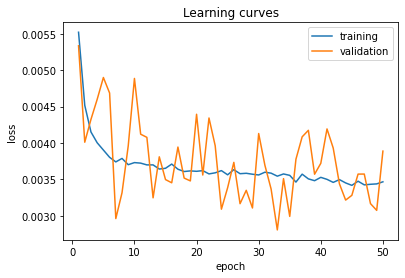

In [140]:
EPOCHS = 50
for epoch in range(0, EPOCHS):
    for is_training in [True, False]:   
        model.train(is_training)
        epoch_loss = 0

        # note the custom collate_fn above: ref_reads and alt_reads 2D tensors of all reads, one read per row, 
        # labels is a 1D tensor, ref_counts and alt_counts are lists
        loader = train_loader if is_training else valid_loader
        for batch, (ref_reads, alt_reads, ref_counts, alt_counts, info, labels, positions, filters) in enumerate(loader):
            if batch % 1000 == 0:
                print("Epoch " + str(epoch) +": " + ("training " if is_training else "validating ") + "batch " + str(batch))
                clear_output(wait=True)
            
            predictions, scores = model(ref_reads, alt_reads, ref_counts, alt_counts, info)              
            loss = criterion(predictions, labels) #+ 0.00*artifact_score_regularizer(scores, labels)
            epoch_loss += loss.item()
          
            if is_training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        (train_losses if is_training else valid_losses).append(epoch_loss / (len(loader)*BATCH_SIZE))
    # end of epoch
# model is trained

fig, learning_curve = plot_learning_curves(train_losses, valid_losses) 

In [109]:
calibrated_model = TemperatureScaledReadSetClassifier(model)
calibrated_model.set_temperature(valid_loader)

Before temperature - NLL: 0.224
Optimal temperature: 0.839
After temperature - NLL: 0.229


TemperatureScaledReadSetClassifier(
  (model): ReadSetClassifier(
    (phi): LinearStack(
      (layers): ModuleList(
        (0): Linear(in_features=11, out_features=20, bias=True)
        (1): Linear(in_features=20, out_features=20, bias=True)
      )
      (bn): ModuleList()
    )
    (omega): LinearStack(
      (layers): ModuleList(
        (0): Linear(in_features=5, out_features=10, bias=True)
      )
      (bn): ModuleList()
    )
    (rho): LinearStack(
      (layers): ModuleList(
        (0): Linear(in_features=50, out_features=10, bias=True)
      )
      (bn): ModuleList()
    )
    (score): Linear(in_features=10, out_features=1, bias=True)
  )
)

(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba60d875e0>,
       dtype=object))

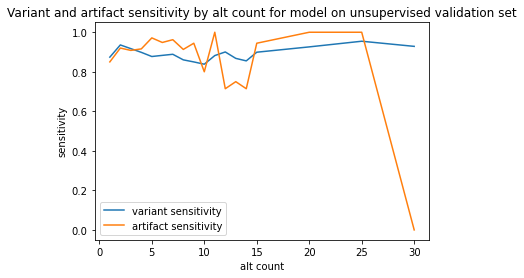

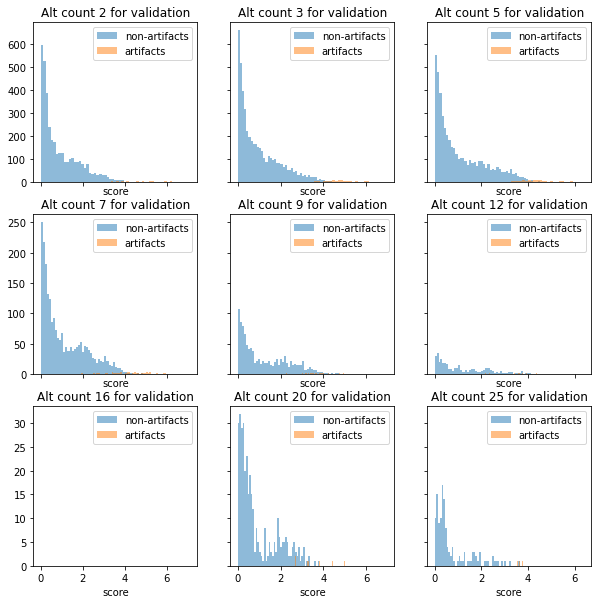

In [141]:
valid_stats = get_validation_stats(model, valid_loader)      
plot_sensitivities(valid_stats.confusion_matrices(), "model on unsupervised validation set")
plot_scores(valid_stats.artifact_scores(), valid_stats.non_artifact_scores(), "validation")

(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba8e3aed60>,
       dtype=object))

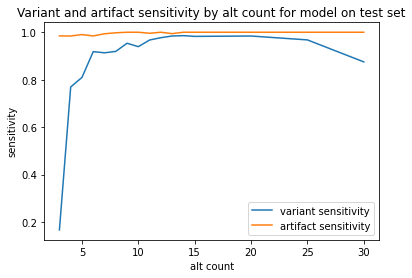

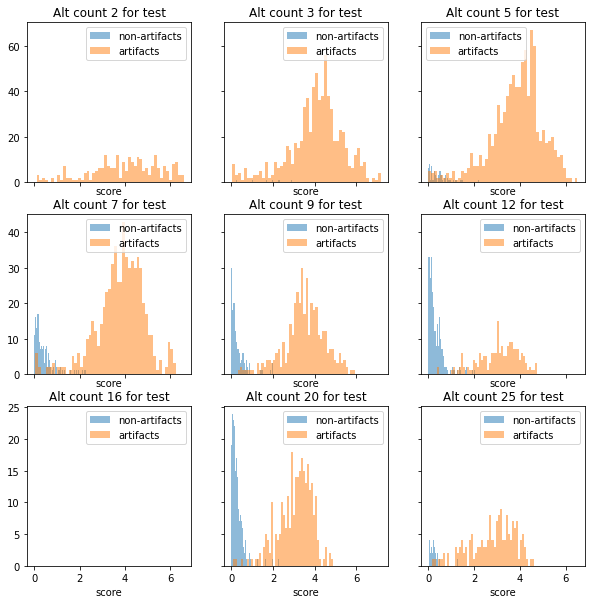

In [142]:
test_stats = get_validation_stats(model, test_loader, {'normal_artifact'}, -4)
plot_sensitivities(test_stats.confusion_matrices(), "model on test set")
plot_scores(test_stats.artifact_scores(), test_stats.non_artifact_scores(), "test")

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fba8acbafd0>)

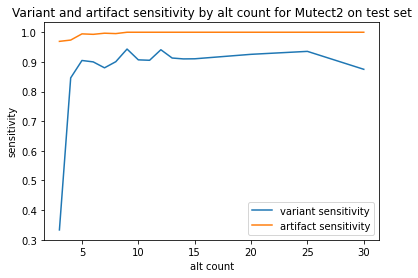

In [118]:
m2_stats = get_m2_validation_stats(test_loader)
plot_sensitivities(m2_stats.confusion_matrices(), "Mutect2 on test set")

In [143]:
print((test_stats.sensitivity(), test_stats.precision()))
print((m2_stats.sensitivity(), m2_stats.precision()))

(0.960852959898154, 0.9827473958333334)
(0.9121578612348823, 0.9754935330156569)


In [121]:
test_stats.confusion, m2_stats.confusion

([[3119, 23], [361, 6801]], [[2866, 276], [72, 7090]])

In [86]:
test_stats.worst_missed_artifacts(5)

[(0.1896074116230011, '3:154213414', {'haplotype', 'panel_of_normals'}),
 (0.2702466547489166, '2:171894122', {'haplotype', 'panel_of_normals'}),
 (0.3536185920238495, '13:61787604', {'PASS'}),
 (0.40648579597473145, '6:104947544', {'haplotype', 'panel_of_normals'}),
 (0.4086052179336548, '3:154213412', {'haplotype', 'panel_of_normals'}),
 (0.4946744740009308, '4:45495101', {'PASS'}),
 (0.5664034485816956, 'X:41190284', {'panel_of_normals'}),
 (0.632560670375824,
  '8:10853035',
  {'clustered_events', 'haplotype', 'panel_of_normals'}),
 (0.7032024264335632,
  '3:15608348',
  {'clustered_events', 'haplotype', 'panel_of_normals'}),
 (0.8218171000480652, '2:212329707', {'panel_of_normals'}),
 (0.9268468022346497, '3:63428587', {'panel_of_normals'}),
 (1.016925573348999, '7:11286850', {'haplotype', 'panel_of_normals'}),
 (1.129881739616394, '6:20927169', {'haplotype', 'panel_of_normals'}),
 (1.1746221780776978, '11:42435619', {'PASS'}),
 (1.2398161888122559, '5:126650182', {'panel_of_norma